In [127]:
import os
import math
import numpy as np
import pandas as pd
from pylab import plt, mpl
import datetime as dt
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'
from sklearn.preprocessing import StandardScaler
from pandas_datareader import DataReader
from datetime import datetime

url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'
symbol = 'AAPL.O'

data = pd.DataFrame(pd.read_csv(url, index_col=0,
                                        parse_dates=True).dropna()[symbol])

In [172]:
baba = DataReader('BABA',  'yahoo', datetime(2014,9,14), datetime(2020,10,16))
baba = pd.DataFrame(baba.loc[:,'Adj Close'])
baba.columns = ['BABA']
data = baba

The previous section lays out the blueprint for vectorized backtesting on the basis of a simple, easy-to-visualize trading strategy. We are going to apply vectorized backtesting to DNN-based trading strategies.The following trains a Keras DNN model. We are going to use the following technical indicators as features in our model.
returns, minimun price over a window, maximum price over a window, the momentum indicator and the voloatility.

In [173]:
def add_lags(dataframe, symbol, lags, features, window=20):
    cols = []
    df = dataframe.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift(1))
    df['sma'] = df[symbol].rolling(window).mean()
    df['min'] = df[symbol].rolling(window).min()
    df['max'] = df[symbol].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

Let's choose `lags=5` and `features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']` to generate the data for our model

lags = 5
features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']
data, cols = add_lags(data, symbol, lags,features, window=20)

In [174]:
lags = 5
features = ['BABA', 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']
data, cols = add_lags(data, 'BABA', lags,features, window=20)

In [175]:
import random
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.regularizers import l1
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import warnings


In [176]:
#To ignore all warnings in model output
warnings.filterwarnings("ignore")
random.seed(50) #for reproducibility

In [177]:
optimizer = Adam(learning_rate=0.0001)

In [178]:
def create_model(hl=2, hu=128, dropout=False, rate=0.3,
                 regularize=False, reg=l1(0.0005),
                 optimizer=optimizer, input_dim=len(cols)):
    if not regularize:
        reg = None
        model = Sequential()
        model.add(Dense(hu, input_dim=input_dim,
                          activity_regularizer=reg,
                          activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu',
                        activity_regularizer=reg))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                   metrics=['accuracy'])
    return model

In [179]:
def create_model(hl=2, hu=128, dropout=False, rate=0.3,
                 regularize=False, reg=l1(0.0005),
                 optimizer=optimizer, input_dim=len(cols)):
    model = Sequential()
    if not regularize:
        reg = None
    model.add(Dense(hu, input_dim=input_dim,
                          activity_regularizer=reg,
                          activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu',
                        activity_regularizer=reg))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                   metrics=['accuracy'])
    return model

Let's train-test split the historical data on a sequential manner, and train the DNN model based on normalized features data:

from sklearn.model_selection import TimeSeriesSplit #better way of splitting to be used later after successfully running first version of model

### Creation of training and testing samples and model creation

We are going to use 10% of the samples for testing

In [180]:
sample_numbers = data.shape[0]
test_sample = int(0.1 * sample_numbers)
#delta =dt.timedelta(-test_sample)
#split_point = data.index[-1] + delta
split_point = list(data.index)[sample_numbers - test_sample]
train = data.loc[:split_point].copy()
test = data.loc[split_point:]
#scaler = StandardScaler()
mu, std = train.mean(), train.std()
train_ = (train - mu) / std
test = data.loc[split_point:].copy()
test_ = (test - mu) / std
#train_ = scaler.fit_transform(train)
model = create_model(hl=2, hu=64, dropout=True, regularize=True)
model.fit(train_[cols], train['d'],
                 epochs=20, verbose=False,
                 validation_split=0.2, shuffle=False)

In [181]:
model.evaluate(train_[cols], train['d']) 
model.metrics_names

1357/1357 [==============================] - 0s 349us/step


[0.9586591721020293, 0.522476077079773]

['loss', 'accuracy']

Vectorized backtesting can now be applied to judge the economic performance of the DNN-based trading strategy in-sample based on the model’s predictions.
In this context, an upward prediction is naturally interpreted as a long position and a downward prediction as a short position:

In [182]:
train['p'] = np.where(model.predict(train_[cols]) > 0.5, 1, -1)

In [183]:
train.loc[:,['p','r']].head()

,p,r
Date,,
2014-10-24,-1,0.0138
2014-10-27,-1,0.0210
2014-10-28,1,0.0191
2014-10-29,-1,-0.0138
2014-10-30,1,0.0043


In [184]:
train['s'] = train['p'] * train['r']

In [185]:
train.loc[:,['p','r','s']].head()

,p,r,s
Date,,,
2014-10-24,-1,0.0138,-0.0138
2014-10-27,-1,0.0210,-0.0210
2014-10-28,1,0.0191,0.0191
2014-10-29,-1,-0.0138,0.0138
2014-10-30,1,0.0043,0.0043


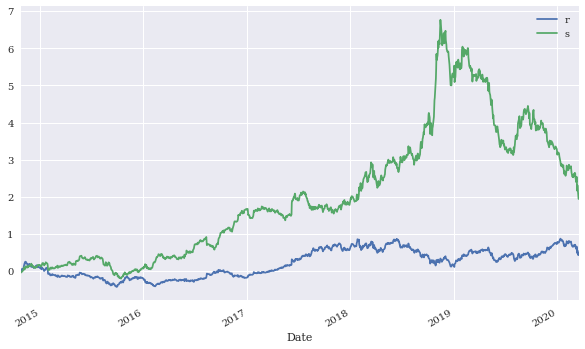

In [186]:
cumulative_returns = train[['r', 's']].add(1).cumprod().sub(1)
cumulative_returns.plot(figsize=(10, 6));

### Out-of-sample performance

In [187]:
model.evaluate(test_[cols], test['d'])

150/150 [==============================] - 0s 380us/step


[1.0626709620157877, 0.6266666650772095]

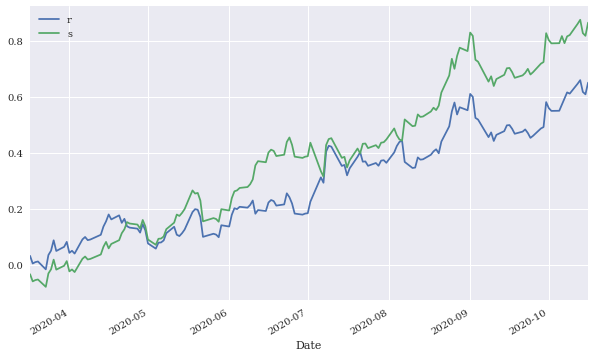

In [188]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, -1)
test['p'].value_counts()
test['s'] = test['p'] * test['r']
cumulative_returns_test = test[['r', 's']].add(1).cumprod().sub(1)
cumulative_returns_test.plot(figsize=(10, 6));

In [189]:
test['p'].value_counts()

 1    122
-1     28
Name: p, dtype: int64

## Ideas to improve the model
- Add addtitional indicators such bollingers band, etc (checkout the packages for algorithmic trading)
- suggest adding sentiment analysis, etc

### Model evaluation
Calculate Sharpe Ratio, Maxdrawdown, ... etc.

#### Add references
- Machine learning for AI, Yves Ipsich
- [python for trading](https://www.datacamp.com/community/tutorials/finance-python-trading)